# Experiments to Malaria Project

#### This notebook describes performed experiments, qualitative analysis and results discussion

<a id='imports'></a>
### Imports

In [ ]:
! pip install shap lime synapseclient

In [ ]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import lime
import math
import seaborn as sns

import zipfile as zp
import synapseclient as syna
from getpass import getpass

from lime import lime_tabular

from termcolor import colored
from datetime import datetime
from numpy import interp

from sklearn.model_selection import KFold, train_test_split

from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id='functions_definition'></a>
## Functions definition

In [ ]:
# Function to plot a histogram that shows the number of NaN values for each column.
def plot_hist_nan(df: pd.DataFrame, plot_name):
        
    nan_df = pd.DataFrame(df.isna().sum().tolist(), df.columns.tolist()).reset_index()
    nan_df.columns = ['column_name', 'total_nan']
    nan_df['nan_perc'] = 100*round(nan_df['total_nan']/len(df),3)
    nan_df = nan_df.sort_values('total_nan', ascending=False)
    nan_df = nan_df[nan_df['total_nan'] > 0]
    
    fig, ax = plt.subplots(figsize=(10,6))
    
    sns.barplot(x="nan_perc", y="column_name", data=nan_df)
    ax.set_ylabel('Columns', fontsize = 10)
    ax.set_xlabel('NaN %', fontsize = 10)    
    ax.tick_params(length=10, width=2, labelsize=10)
    
    dst = "../out/"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + "/" + plot_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')
    
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def plot_confusion_matrix(results, labels, image_name):
        
    sns.set(font_scale = 1.5)
    plt.figure(figsize=(10,8))
    threshold = 0.5
    index = 0
        
    for result in results:
                            
        cm = confusion_matrix(result.y_pred, result.y_test)
        ax = plt.subplot(2, 2, index+1)

        sns.set_palette("PuBuGn_d")
        
        #if index == 0 or index == 2:
        #    show_scale = False
        #else:
        #    show_scale = True
            
        sum_0 =  cm.sum(axis=1)[0]
        sum_1 = cm.sum(axis=1)[1]
        
        cm_aux = np.zeros((2,2))
        cm_aux[0][0] = (cm[1][1] / sum_1)
        cm_aux[0][1] = (cm[1][0] / sum_1)
        cm_aux[1][0] = (cm[0][1] / sum_0)
        cm_aux[1][1] = (cm[0][0] / sum_0)
        
        sns.heatmap(cm_aux, annot=True, ax = ax, fmt=".2%", cmap="Blues", cbar=False)
        #sns.heatmap(cm_aux, annot=True, ax = ax, cmap="Blues", cbar=False)
        
        ax.set_title(result.model_name)
        ax.yaxis.set_ticklabels(labels)
        ax.xaxis.set_ticklabels(labels)
        
        if index == 0 or index == 1:
            ax.set_xlabel('');
        else:
            ax.set_xlabel('Predicted labels');
            
        if index == 1 or index == 3:
            ax.set_ylabel(''); 
        else:
            ax.set_ylabel('True labels')
            
        index = index + 1
        
    dst = "../out/"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + image_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')
    
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.4)
    plt.show()
    

In [ ]:
def plot_roc_curve(results, file_name):
        
    plt.figure(figsize=(10,8))
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    i = 0
    
    colors = ['r','b','g']
    
    for idx,result in enumerate(results):
    
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        mean_tpr = np.mean(result.tprs, axis=0)
        mean_tpr[-1] = 1.0
        std_auc = np.std(result.aucs)
        avg_auc = metrics.roc_auc_score(result.y_test, result.y_pred)
        
        plt.plot(mean_fpr, mean_tpr, color=colors[idx],
                 label=result.model_name + ' (AUC = %0.3f $\pm$ %0.3f)' % (avg_auc, std_auc), lw=2, alpha=0.8)
        
        std_tpr = np.std(result.tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        
        if i == 0:
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=.2)
        else:
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=.2)
        i = i + 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity', size=15)
    plt.ylabel('Sensitivity', size=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.title('ROC CURVE')    
    
    #dst = "../out/"
    dst = "./"
    if os.path.isdir(dst) == False:
        os.makedirs(dst)
    dst = dst + "/" + file_name + ".pdf"
    plt.savefig(dst, bbox_inches = 'tight')
    
    plt.show()

In [ ]:
def generate_performance_stats(y_test, y_pred): 
    target_names = ['Outro Tratamento', 'Tratamento 11'] 
    cm = confusion_matrix(y_test, y_pred)
    print("Accuracy: {}\n".format(metrics.accuracy_score(y_test,y_pred)))
    print("Auc-macro: {}\n".format(metrics.roc_auc_score(y_test,y_pred))) 
    print("Auc-weighted: {}\n".format(metrics.roc_auc_score(y_test,y_pred, average='weighted')))
    #print("Log loss: {}\n".format(metrics.log_loss(y_test,y_pred)))
    print("Confusion Matrix: \n{}\n".format(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])))
    print("Classification Report: \n{}\n".format(classification_report(y_test, y_pred, target_names=target_names)))

In [ ]:
def create_balanced_dataset(df: pd.DataFrame, percent):
    # Class count
    count_class_0, count_class_1 = df['target'].value_counts() * percent
    count_class_0 = int(count_class_0)
    count_class_1 = int(count_class_1)

    # Divide by class
    df_class_0 = df[df['target'] == 0]
    df_class_1 = df[df['target'] == 1]
    
    df_class_1 = df_class_1.sample(count_class_1, random_state=1)
    
    df_class_0_under = df_class_0.sample(count_class_1, random_state=1)
    df_balanced = pd.concat([df_class_0_under, df_class_1], axis=0)    
    
    return df_balanced

In [ ]:
def evaluate_model(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame):
    """
    Used to evaluate a given model. Just an API wrapper.    
    Returns the fitted model along with the predictions generated for the test set
    """
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    y_preds_proba = model.predict_proba(X_test)
    return model, y_preds, y_preds_proba

In [ ]:
def perform_cv(df_train, models, n_folds, use_oversampling):
        
    results = []
    mean_fpr = np.linspace(0, 1, 100)
    models_predictions = {}

    for model_alias in models:
    
        print("Model: {}\n".format(model_alias))
        y_preds = []
        y_probs = []
        y_tests = []
        tprs = []
        aucs = []
        thresholds = []
        model = models[model_alias]

        i = 0
        kf = KFold(n_splits=n_folds, random_state=13, shuffle=True)
        #model_predicted = []
        #model_gt = []
    
        for index in kf.split(df_train):

            print("Fold[{}]\n".format(i+1))

            X_train, X_test = df_train.iloc[index[0]], df_train.iloc[index[1]]
            
            if use_oversampling:
                X_train = create_balanced_dataset(X_train, 1.0)
                     
            y_train = X_train['target']
            X_train = X_train.drop(['target'], axis = 1)
                     
            y_test = X_test['target']
            X_test = X_test.drop(['target'], axis = 1)
            
            model_fit, y_pred, y_pred_proba = evaluate_model(model, X_train, X_test, y_train, y_test)                   

            # Compute ROC curve and area the curve
            fpr, tpr, threshold = roc_curve(y_test, y_pred_proba[:,1])
            prec, rec, tre = precision_recall_curve(y_test, y_pred_proba[:,1])
            
            y_preds = np.append(y_preds, y_pred)
            y_probs = np.append(y_probs, y_pred_proba[:,1])
            y_tests = np.append(y_tests, y_test)        
            
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            thresholds.append(threshold)
            i = i + 1
    
        generate_performance_stats(y_preds, y_tests)

        result = RESULT(model_alias, y_preds, y_probs, y_tests, tprs, aucs, thresholds)
        results.append(result)
        models_predictions[model_alias] = (y_preds, y_tests)
        print("########################################################\n")
    
    return results, models_predictions

<a id='loading_dataset'></a>
## Load dataset

In [ ]:
 # Getting BD from Synapse
 syn = syna.Synapse() 
 syn.login(input('Sybapse User: '), getpass('Passwd:')) 
 
 # Obtain a pointer and download the data
 # sivep_completo.csv.zip - https://www.synapse.org/#!Synapse:syn24225699
 dataset = syn.get(entity='syn25713874')
 
 # Get the path to the local copy of the data file 
 filepath = dataset.path

 with zp.ZipFile(filepath,"r") as zip_ref:
    zip_ref.extractall("")


Sybapse User: evertonjsilva
Passwd:··········
Welcome, Everton Silva!



Adicionei low_memory=False, por causa do warning de dtype

In [ ]:
df_full = pd.read_csv('./dados/sivep_data.csv', sep=';', low_memory=False, encoding="ISO-8859-1")
df_full.shape

(3737123, 51)

In [ ]:
df_full.head()

,ï»¿uid,ano,cod_noti,dt_notif,dt_envlo,dt_digit,sem_noti,tipo_lam,uf_notif,mun_noti,cod_unin,cod_agen,dt_nasci,id_pacie,id_dimea,sexo,raca,pais_res,uf_resid,mun_resi,loc_resi,sintomas,dt_sinto,cod_ocup,uf_infec,pais_inf,mun_infe,loc_infe,dt_exame,res_exam,qtd_para,qtd_cruz,dt_trata,esquema,hemoparasi,exame,examinador,id_lvc,gestante,vivax,falciparum,niv_esco,id_pacie_anos,nu_predi_infe,nu_habit_infe,zona_infe,categori_infe,nu_predi_resi,nu_habit_resi,zona_resi,categori_resi
0,1,2007,1,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,11,209890.0,NaN,6.0,Anos,Feminino,NaN,BRASIL,Acre,120042.0,53.0,Com,2007-01-01,Doméstica,Acre,BRASIL,120042.0,53.0,2007-01-02,Vivax,NaN,++,2007-07-02,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não se aplica,NaN,NaN,Não se aplica,6,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
1,2,2007,2,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,11,209890.0,NaN,2.0,Anos,Masculino,NaN,BRASIL,Acre,120042.0,53.0,Com,2007-01-02,Doméstica,Acre,BRASIL,120042.0,53.0,2007-01-02,Vivax,NaN,< +/2,2007-07-02,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não se aplica,NaN,NaN,Não se aplica,2,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
2,3,2007,14,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,11,208614.0,1959-04-30,47.0,Anos,Feminino,NaN,BRASIL,Acre,120042.0,53.0,Com,2007-01-01,Doméstica,Acre,BRASIL,120042.0,53.0,2007-01-02,Vivax,NaN,< +/2,2007-01-02,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não,NaN,NaN,Analfabeto,47,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
3,4,2007,18,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,11,208614.0,NaN,15.0,Anos,Feminino,NaN,BRASIL,Acre,120042.0,53.0,Com,2006-12-30,Doméstica,Acre,BRASIL,120042.0,53.0,2007-01-02,Vivax,NaN,+/2,2007-01-02,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não,NaN,NaN,5ª a 8ª série incompleta do EF,15,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
4,5,2007,24,2007-01-02,2011-03-23,2007-01-06,1.0,Detecção Passiva,AC,120042,11,209890.0,1984-12-13,22.0,Anos,Masculino,NaN,BRASIL,Acre,120042.0,53.0,Com,2007-01-02,Agricultura,Acre,BRASIL,120042.0,53.0,2007-01-03,Vivax,NaN,+,2007-01-03,"Infecções pelo P. vivax, ou P. ovale com Cloro...",NaN,NaN,NaN,Não LVC,Não se aplica,NaN,NaN,5ª a 8ª série incompleta do EF,22,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal


## Data Preprocessing

In [ ]:
df_prep = df_full.copy()

In [ ]:
df_prep.columns

Index(['ï»¿uid', 'ano', 'cod_noti', 'dt_notif', 'dt_envlo', 'dt_digit',
       'sem_noti', 'tipo_lam', 'uf_notif', 'mun_noti', 'cod_unin', 'cod_agen',
       'dt_nasci', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'pais_res',
       'uf_resid', 'mun_resi', 'loc_resi', 'sintomas', 'dt_sinto', 'cod_ocup',
       'uf_infec', 'pais_inf', 'mun_infe', 'loc_infe', 'dt_exame', 'res_exam',
       'qtd_para', 'qtd_cruz', 'dt_trata', 'esquema', 'hemoparasi', 'exame',
       'examinador', 'id_lvc', 'gestante', 'vivax', 'falciparum', 'niv_esco',
       'id_pacie_anos', 'nu_predi_infe', 'nu_habit_infe', 'zona_infe',
       'categori_infe', 'nu_predi_resi', 'nu_habit_resi', 'zona_resi',
       'categori_resi'],
      dtype='object')

**Converter colunas de datas para datetime**

In [ ]:
date_cols = ['dt_sinto', 'dt_notif', 'dt_exame', 'dt_trata']
df_prep[date_cols] = df_prep[date_cols].apply(pd.to_datetime,  errors='coerce')
df_prep[date_cols].head()

,dt_sinto,dt_notif,dt_exame,dt_trata
0,2007-01-01,2007-01-02,2007-01-02,2007-07-02
1,2007-01-02,2007-01-02,2007-01-02,2007-07-02
2,2007-01-01,2007-01-02,2007-01-02,2007-01-02
3,2006-12-30,2007-01-02,2007-01-02,2007-01-02
4,2007-01-02,2007-01-02,2007-01-03,2007-01-03


**Deixar somente registros a partir de 2011 considerando a data em que o paciente sentiu os primeiros sintomas da malária: dt_sinto**

In [ ]:
df_prep = df_prep[df_prep['dt_sinto'] > pd.to_datetime("2010-12-31")]
df_prep.shape

(1896254, 51)

In [ ]:
#Drop ununsable features
cols_to_drop = ['ï»¿uid', 'ano', 'cod_noti', 'dt_envlo', 'dt_digit', 'sem_noti', 'uf_notif', 'mun_noti', 'cod_unin',
                'cod_agen', 'dt_nasci', 'pais_res', 'uf_resid', 'mun_resi', 'loc_resi', 'examinador',
                'nu_predi_infe', 'nu_habit_infe', 'nu_predi_resi', 'nu_habit_resi', 'zona_resi', 'categori_resi',
                'id_pacie_anos']
df_prep = df_prep.drop(columns=cols_to_drop, axis=1)

In [ ]:
df_prep.columns

Index(['dt_notif', 'tipo_lam', 'id_pacie', 'id_dimea', 'sexo', 'raca',
       'sintomas', 'dt_sinto', 'cod_ocup', 'uf_infec', 'pais_inf', 'mun_infe',
       'loc_infe', 'dt_exame', 'res_exam', 'qtd_para', 'qtd_cruz', 'dt_trata',
       'esquema', 'hemoparasi', 'exame', 'id_lvc', 'gestante', 'vivax',
       'falciparum', 'niv_esco', 'zona_infe', 'categori_infe'],
      dtype='object')

In [ ]:
cols = df_prep.columns
for col in cols:
    print(col, ": ", df_prep[col].dtype)
    print(df_prep[col].unique(), "\n")

dt_notif :  datetime64[ns]
['2009-12-30T00:00:00.000000000' '2011-01-31T00:00:00.000000000'
 '2011-02-17T00:00:00.000000000' ... '2020-06-13T00:00:00.000000000'
 '2020-06-14T00:00:00.000000000' '2020-06-16T00:00:00.000000000'] 

tipo_lam :  object
['Detecção Ativa' 'LVC (ficha antiga)' 'Detecção Passiva'] 

id_pacie :  float64
[3.100e+01 1.800e+01 2.100e+01 9.000e+00 4.600e+01 2.000e+00 1.200e+01
 2.600e+01 6.000e+00 1.900e+01 2.400e+01 3.200e+01 4.700e+01 3.600e+01
 8.000e+00 2.900e+01 2.300e+01 1.700e+01 1.000e+01 6.200e+01 1.600e+01
 5.700e+01 4.100e+01 2.700e+01 1.500e+01 2.200e+01 1.100e+01 3.700e+01
 3.800e+01 2.000e+01 3.000e+01 3.900e+01 4.300e+01 3.500e+01 6.600e+01
 4.800e+01 3.300e+01 2.800e+01 6.000e+01 4.000e+00 6.400e+01 5.300e+01
 5.000e+01 1.400e+01 3.400e+01 5.600e+01 4.000e+01 7.000e+00 6.100e+01
 3.000e+00 5.400e+01 4.900e+01 5.000e+00 7.400e+01 5.500e+01 5.100e+01
 1.000e+00 2.500e+01 4.200e+01 5.900e+01 1.300e+01 7.200e+01 6.700e+01
 4.500e+01 5.800e+01 6.900e+01 4

**Remover registros onde id_lvc é LVC**

In [ ]:
df_prep = df_prep[df_prep['id_lvc'] != 'LVC']

In [ ]:
df_prep.shape

(1594530, 28)

**Remover registros onde de pacientes com idade inferior a 1 ano**

In [ ]:
filter = (df_prep['id_dimea'] == "Anos") & (df_prep['id_pacie'] >= 1) | (df_prep['id_dimea'] == "Meses") & (df_prep['id_pacie'] >= 12) | (df_prep['id_dimea'] == "Dias") & (df_prep['id_pacie'] >= 365)
df_prep = df_prep.loc[filter]

In [ ]:
df_prep.shape

(1573183, 28)

**Remover coluna id_lvc pois ela agora só possui um único valor**

In [ ]:
df_prep['id_lvc'].unique()

array(['Não LVC'], dtype=object)

In [ ]:
df_prep.drop(columns='id_lvc', axis=1, inplace=True)

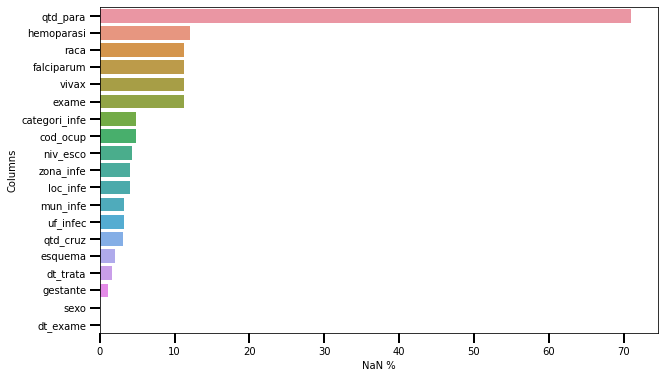

In [ ]:
# Let's see the barplot that shows the number of nan values by column
plot_hist_nan(df_prep, 'barplot_nan')

In [ ]:
nan_df = pd.DataFrame(df_prep.isna().sum().tolist(), df_prep.columns.tolist()).reset_index()
nan_df.columns = ['column_name', 'total_nan']
nan_df['nan_perc'] = 100*round(nan_df['total_nan']/len(df_prep),3)
nan_df = nan_df.sort_values('total_nan', ascending=False)
nan_df

,column_name,total_nan,nan_perc
15,qtd_para,1117312,71.0
19,hemoparasi,190929,12.1
5,raca,175666,11.2
23,falciparum,175622,11.2
22,vivax,175622,11.2
20,exame,175614,11.2
26,categori_infe,76241,4.8
8,cod_ocup,75078,4.8
24,niv_esco,67144,4.3
25,zona_infe,63927,4.1


**Remover a coluna qtd_para pois tem mais de 70% de valores faltantes.**

In [ ]:
df_prep.drop(columns=['qtd_para'], axis=1, inplace=True)

In [ ]:
df_prep.columns

Index(['dt_notif', 'tipo_lam', 'id_pacie', 'id_dimea', 'sexo', 'raca',
       'sintomas', 'dt_sinto', 'cod_ocup', 'uf_infec', 'pais_inf', 'mun_infe',
       'loc_infe', 'dt_exame', 'res_exam', 'qtd_cruz', 'dt_trata', 'esquema',
       'hemoparasi', 'exame', 'gestante', 'vivax', 'falciparum', 'niv_esco',
       'zona_infe', 'categori_infe'],
      dtype='object')

In [ ]:
df_prep.shape

(1573183, 26)

**Deletar registros os quais tenham pelo menos uma coluna com valor faltante**

In [ ]:
df_prep.dropna(axis=0, inplace=True)
df_prep.shape

(1223696, 26)

In [ ]:
df_prep.isnull().sum()
#df_prep = df_prep[df_prep['esquema'].notna()]

dt_notif         0
tipo_lam         0
id_pacie         0
id_dimea         0
sexo             0
raca             0
sintomas         0
dt_sinto         0
cod_ocup         0
uf_infec         0
pais_inf         0
mun_infe         0
loc_infe         0
dt_exame         0
res_exam         0
qtd_cruz         0
dt_trata         0
esquema          0
hemoparasi       0
exame            0
gestante         0
vivax            0
falciparum       0
niv_esco         0
zona_infe        0
categori_infe    0
dtype: int64

In [ ]:
df_prep.shape

(1223696, 26)

**CHECKPOINT**

In [ ]:
df_prep_notnull = df_prep.copy()

## Prepare the Dataset

**Remover colunas de datas e outras relacionadas à localização**

Removemos as features relacionadas à localização, pois o modelo deve considerar somente features pertininentes ao paciente.

In [ ]:
df_prep_notnull.drop(columns=['dt_sinto', 'dt_notif', 'dt_exame', 'dt_trata', 
                              'uf_infec', 'pais_inf', 'zona_infe', 'categori_infe', 
                              'mun_infe', 'loc_infe'], axis=1, inplace=True)

In [ ]:
df_prep_notnull.columns

Index(['tipo_lam', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'sintomas',
       'cod_ocup', 'res_exam', 'qtd_cruz', 'esquema', 'hemoparasi', 'exame',
       'gestante', 'vivax', 'falciparum', 'niv_esco'],
      dtype='object')

In [ ]:
# All features are categorical and object type. So we need to convert the object type to numerical type.
# In this process the nan values are converted to -1

obj_cols = df_prep_notnull.select_dtypes(['object']).columns
df_prep_notnull[obj_cols] = df_prep_notnull[obj_cols].astype('category')
df_prep_notnull[obj_cols] = df_prep_notnull[obj_cols].apply(lambda x: x.cat.codes)
df_prep_notnull[obj_cols] = df_prep_notnull[obj_cols].astype('int64')
df_prep_notnull[df_prep_notnull[obj_cols] == -1] = np.nan

In [ ]:
for col in obj_cols:
    print(col, ": ", df_prep_notnull[col].dtype)
    print(df_prep_notnull[col].unique(), "\n")

tipo_lam :  int64
[0 1 2] 

id_dimea :  int64
[0 1] 

sexo :  int64
[1 0] 

raca :  int64
[3 4 2 1 0] 

sintomas :  int64
[0 1] 

cod_ocup :  int64
[ 0  8 11  3  9  1 10  4  2  7  5  6] 

res_exam :  int64
[9 3 0 2 8 4 5 1 6 7] 

qtd_cruz :  int64
[0 4 1 5 2 3] 

esquema :  int64
[11 10 18 24 25 14 17  3 23  6  5 16 15  1 26  2  7 27  8 13  4 19  0 22
 20 28  9 12 21] 

hemoparasi :  int64
[1 2 3 0 4] 

exame :  int64
[0 1] 

gestante :  int64
[5 4 1 2 0 3] 

vivax :  int64
[0 1] 

falciparum :  int64
[0 1] 

niv_esco :  int64
[6 8 2 0 9 3 7 1 4 5] 



A coluna ESQUEMA será utilizada como feature alvo (target). Essa feature possui 20 valores possíveis, ou seja, teríamos 20 classes. Vamos analisar a distribuição dessas classes através de um gráfico de barras.

In [ ]:
df_esquema = pd.DataFrame(columns=['esquema'])
df_esquema["esquema"] = df_prep["esquema"].unique().copy()
df_esquema["id_esquema"] = df_esquema["esquema"].astype('category')
cat_columns = df_esquema.select_dtypes(['category']).columns
df_esquema[cat_columns] = df_esquema[cat_columns].apply(lambda x: x.cat.codes)

In [ ]:
df_esquema

,esquema,id_esquema
0,"Infecções pelo P. vivax, ou P. ovale com Cloro...",11
1,"Infecções pelo P. vivax, ou P. ovale com Cloro...",10
2,Infecções por P. falciparum com a combinação f...,18
3,Outro Esquema utilizado,24
4,Prevenção das recaídas frequentes por P. vivax...,25
5,Infecções por P. falciparum com Quinina em 3 d...,14
6,Infecções por P. falciparum com a combinação f...,17
7,Infecções mistas por P. falciparum e P. vivax ...,3
8,Malária grave e complicada pelo P. falciparum ...,23
9,Infecções pelo P. malariae para todas as idade...,6


In [ ]:
df_esquema.to_csv('./esquemas.csv', index=False, sep=",", encoding='utf-8')

In [ ]:
df_plot = df_prep_notnull.copy()
df_plot['id'] = df_plot.index + 1
df_plot = df_plot.groupby('esquema')['id'].count().reset_index()
df_plot.columns = ['esquema', 'count']
df_plot['freq'] = df_plot['count'] / df_plot['count'].sum()
df_plot = df_plot[df_plot['freq'] > 0.01]
df_plot['esquema'] = df_plot['esquema'].astype('str')

#row_names = {'11': 'Infecções pelo P. vivax, ou P. ovale com Cloroquina em 3 dias e Primaquina em 7 dias',
#             '17': 'Infecções por P. falciparum com a combinação fixa de artemeter+lumefantrina em 3 dias',
#             '24': 'Outro Esquema utilizado',
#             '15': 'Infecções por P. falciparum com a combinação fixa de Artemeter + Lumefantrina em 3 dias e primaquina em dose única',
#             '10': 'Infecções pelo P. vivax, ou P. ovale com Cloroquina em 3 dias e Primaquina em 14 dias (esquema longo)'}

row_names = {'11': 'Treatment Scheme 11',
             '17': 'Treatment Scheme 17',
             '24': 'Treatment Scheme 24',
             '15': 'Treatment Scheme 15',
             '10': 'Treatment Scheme 10'}

df_plot.set_index('esquema', inplace=True)
df_plot.rename(index=row_names, inplace=True)
df_plot = df_plot.sort_values(by='freq', ascending=False)
df_plot

,count,freq
esquema,,
Treatment Scheme 11,1012546,0.827449
Treatment Scheme 17,71739,0.058625
Treatment Scheme 24,50675,0.041411
Treatment Scheme 15,36867,0.030128
Treatment Scheme 10,24847,0.020305


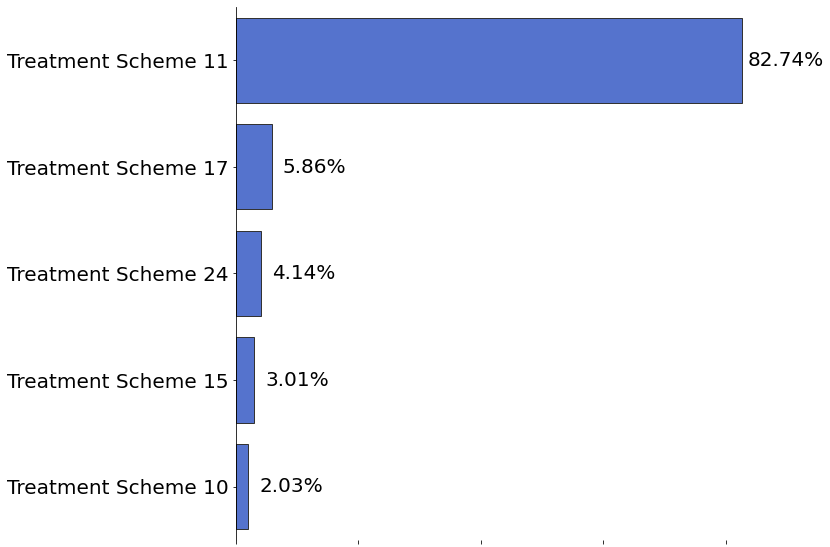

In [ ]:
import textwrap
plt.figure(figsize=(12, 8))

rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.family':'DejaVu Sans',
      'font.size' : 20}

plt.rcParams.update(rc)

#palette="pastel"
ax = sns.barplot(data=df_plot, x="freq", y=df_plot.index, edgecolor=".2", color='royalblue')
ax.set(ylabel='', xlabel='')
ax.set_yticklabels([textwrap.fill(e, 40) for e in df_plot.index], size=20)
ax.set(xticklabels=[])

sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False)

for p in ax.patches:
    width = p.get_width()
    plt.text(0.07+p.get_width(), p.get_y()+0.5*p.get_height(),
             '{:1.2f}%'.format(width*100),
             ha='center', va='center')

plt.tight_layout()
plt.savefig('./treatment_scheme_freq.pdf')
plt.show()

Podemos ver no gráfico que o esquema de tratamento 11 é o mais utilizado, seguido pelos tratamentos 17, 24, 15 2 e 10;

11: Infecções pelo P. vivax, ou P. ovale com Cloroquina em 3 dias e Primaquina em 7 dias

17: Infecções por P. falciparum com a combinação fixa de artemeter+lumefantrina em 3 dias

24: Outro Esquema utilizado

15: Infecções por P. falciparum com a combinação fixa de Artemeter + Lumefantrina em 3 dias e primaquina em dose única

10: Infecções pelo P. vivax, ou P. ovale com Cloroquina em 3 dias e Primaquina em 14 dias (esquema longo)

## First Approach
Utilizar tratamento 11 contra o resto



In [ ]:
df_prep_fa = df_prep_notnull.copy()

In [ ]:
df_prep_fa['target'] = np.where(df_prep_fa['esquema'] == 11, 1, 0)

In [ ]:
df_prep_fa.head()

,tipo_lam,id_pacie,id_dimea,sexo,raca,sintomas,cod_ocup,res_exam,qtd_cruz,esquema,hemoparasi,exame,gestante,vivax,falciparum,niv_esco,target
1721039,0,26.0,0,1,3,0,0,9,0,11,1,0,5,0,0,6,1
1721045,0,43.0,0,1,3,0,8,9,4,10,2,0,5,0,0,8,0
1721063,0,28.0,0,1,3,0,8,9,1,11,2,0,5,0,0,2,1
1721072,0,24.0,0,1,4,0,11,9,1,11,1,0,5,0,0,2,1
1721086,0,16.0,0,0,3,0,3,9,1,11,2,0,4,0,0,0,1


In [ ]:
## Apagar a coluna esquema
df_prep_fa.drop(axis=1, columns=['esquema'], inplace=True)

In [ ]:
df_prep_fa.columns

Index(['tipo_lam', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'sintomas',
       'cod_ocup', 'res_exam', 'qtd_cruz', 'hemoparasi', 'exame', 'gestante',
       'vivax', 'falciparum', 'niv_esco', 'target'],
      dtype='object')

In [ ]:
nRows = df_prep_fa.shape[0]
df_prep_fa['target'].value_counts()[1] / nRows

0.8274489742550437

In [ ]:
df_prep_fa['target'].value_counts()[0] / nRows

0.17255102574495626

In [ ]:
df_plot = df_prep_fa.copy()
df_plot['id'] = df_plot.index + 1
df_plot = df_plot.groupby('target')['id'].count().reset_index()
df_plot.columns = ['target', 'count']
df_plot['freq'] = df_plot['count'] / df_plot['count'].sum()
df_plot = df_plot[df_plot['freq'] > 0.01]
df_plot['target'] = df_plot['target'].astype('str')

#row_names = {'0': 'Outro Esquema',
#             '1': 'Infecções pelo P. vivax, ou P. ovale com Cloroquina em 3 dias e Primaquina em 7 dias'}

row_names = {'0': 'Another scheme',
             '1': 'Treatment Scheme 11'}

df_plot.set_index('target', inplace=True)
df_plot.rename(index=row_names, inplace=True)
df_plot = df_plot.sort_values(by='freq', ascending=False)
df_plot

,count,freq
target,,
Treatment Scheme 11,1012546,0.827449
Another scheme,211150,0.172551


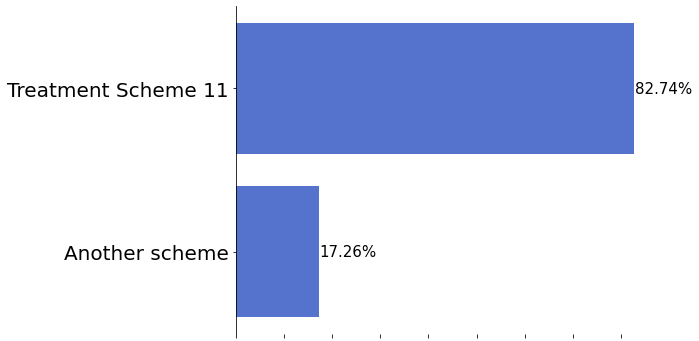

In [ ]:
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.family':'DejaVu Sans',
      'font.size' : 15}

plt.rcParams.update(rc)

#palette="pastel"
ax = sns.barplot(data=df_plot, x="freq", y=df_plot.index, color='royalblue')
ax.set(ylabel='', xlabel='')
ax.set_yticklabels([textwrap.fill(e, 35) for e in df_plot.index], size=20)
ax.set(xticklabels=[])

sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False)

for p in ax.patches:
    width = p.get_width()
    plt.text(0.06+p.get_width(), p.get_y()+0.5*p.get_height(),
             '{:1.2f}%'.format(width*100),
             ha='center', va='center')
    
plt.tight_layout()
plt.savefig('./class_distribution.pdf')
plt.show()

### Dividir a base dados em treinamento e teste - 80/20

In [ ]:
df_prep_fa.columns

Index(['tipo_lam', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'sintomas',
       'cod_ocup', 'res_exam', 'qtd_cruz', 'hemoparasi', 'exame', 'gestante',
       'vivax', 'falciparum', 'niv_esco', 'target'],
      dtype='object')

In [ ]:
X_train, X_test = train_test_split(df_prep_fa, test_size=0.20, random_state=13)
df_train = X_train.copy()

In [ ]:
X_train.shape

(978956, 16)

In [ ]:
X_test.shape

(244740, 16)

### Aplicar validação cruzada no conjunto de treinamento

In [ ]:
class RESULT(object):
    
    def __init__(self, model_name, y_pred, y_prob, y_test, tprs, aucs, thresholds):
        self.model_name = model_name
        self.y_pred = y_pred
        self.y_prob = y_prob        
        self.y_test = y_test
        self.tprs = tprs
        self.aucs = aucs
        self.thresholds = thresholds

In [ ]:
models = {
    'XGBoost': XGBClassifier(),
    'Logistic': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier()
    #'SVM': SVC(gamma='auto')
    #'RF': RandomForestClassifier(n_estimators=100,criterion='gini'),
}

#### 5 folds e Undersampling
A cada iteração do processo de validação cruzada, é aplicado uma subamostragem ao conjunto de treinamento, tornando o conjunto balanceado. 

In [ ]:
n_folds = 5
results_exp1, models_pred_exp1 = perform_cv(df_train, models, n_folds, False)

Model: XGBoost

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Accuracy: 0.933323867466975

Auc-macro: 0.9276315988680396

Auc-weighted: 0.9276315988680396

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        113203    9840
1.0         55433  800480

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.67      0.92      0.78    123043
   Tratamento 11       0.99      0.94      0.96    855913

        accuracy                           0.93    978956
       macro avg       0.83      0.93      0.87    978956
    weighted avg       0.95      0.93      0.94    978956


########################################################

Model: Logistic

Fold[1]



[WARNING] lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fold[2]



[WARNING] lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fold[3]



[WARNING] lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fold[4]



[WARNING] lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fold[5]



[WARNING] lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 0.9313707664082962

Auc-macro: 0.9262836144247629

Auc-weighted: 0.9262836144247629

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        111181    9730
1.0         57455  800590

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.66      0.92      0.77    120911
   Tratamento 11       0.99      0.93      0.96    858045

        accuracy                           0.93    978956
       macro avg       0.82      0.93      0.86    978956
    weighted avg       0.95      0.93      0.94    978956


########################################################

Model: DecisionTree

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Accuracy: 0.912237117909283

Auc-macro: 0.861643336495943

Auc-weighted: 0.861643336495943

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        112603   29883
1.0         56033  780437

Classification Report: 
                  precision    recall  f1

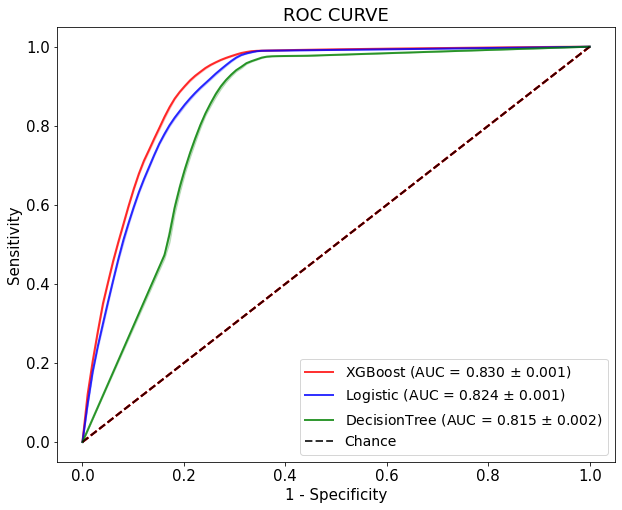

In [ ]:
plot_roc_curve(results_exp1, "roc_curve_balanced")

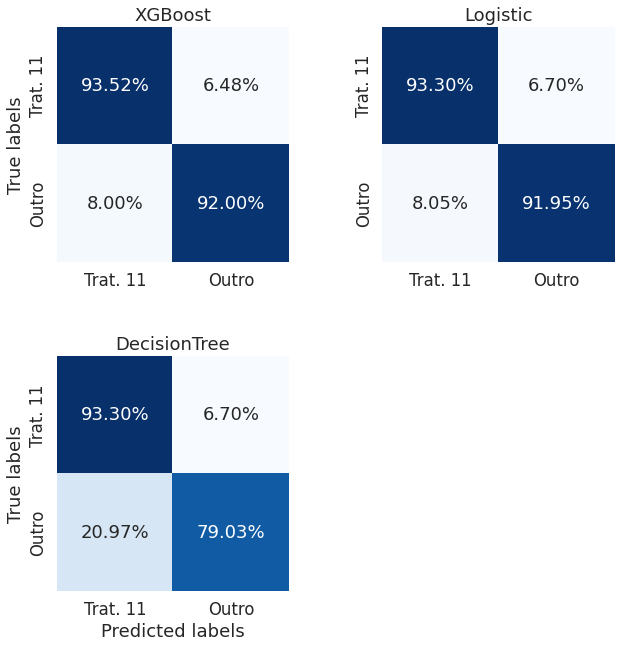

In [ ]:
plot_confusion_matrix(results_exp1, ['Trat. 11', 'Outro'], "confusion_matrix")

#### Criar os modelos finais e testar no conjunto de teste

In [ ]:
X_train, X_test = train_test_split(df_prep_fa, test_size=0.20, random_state=13)

#Usar undersampling
#X_train = create_balanced_dataset(X_train, 1.0)

y_train = X_train['target'].values
X_train = X_train.drop(['target'], axis=1)

y_test = X_test['target'].values
X_test = X_test.drop(['target'], axis=1)

In [ ]:
xgbModel = XGBClassifier()
xgbModel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_test_pred = xgbModel.predict(X_test)
y_test_predProba = xgbModel.predict_proba(X_test)

In [ ]:
generate_performance_stats(y_test, y_test_pred)

Accuracy: 0.9321238865735065

Auc-macro: 0.82768274916615

Auc-weighted: 0.82768274916615

Confusion Matrix: 
Predicted      0       1
Actual                  
0          28384   14130
1           2482  199744

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.92      0.67      0.77     42514
   Tratamento 11       0.93      0.99      0.96    202226

        accuracy                           0.93    244740
       macro avg       0.93      0.83      0.87    244740
    weighted avg       0.93      0.93      0.93    244740




#### Feature importance for XGBoost

In [ ]:
df_featImport = pd.DataFrame(columns=['feature', 'feat_importance'])
df_featImport['feature'] = X_train.columns
df_featImport['feat_importance'] = xgbModel.feature_importances_
df_featImport = df_featImport.sort_values(by='feat_importance', ascending=False)

col_names = {'tipo_lam':'TIPO_LAM', 'id_pacie':'ID_PACIE', 'id_dimea':'em', 'sexo':'Sexo', 'raca':'Raça/Cor', 'sintomas':'Sintomas', 'cod_ocup':'COD_OCUP',
             'res_exam':'RES_EXAME', 'qtd_cruz':'Qtd cruzes', 'hemoparasi':'HEMOPARASI', 'exame':'Tipo do exame', 'gestante':'GESTANTE', 'vivax':'Trat. vivax',
             'falciparum':'Trat. falciparum', 'niv_esco':'Escolaridade', 'mun_infe':'MUN_INF', 'loc_infe':'Local de infecção'}
df_featImport.set_index('feature', inplace=True) 
df_featImport.rename(index=col_names, inplace=True)
df_featImport = df_featImport[0:5]

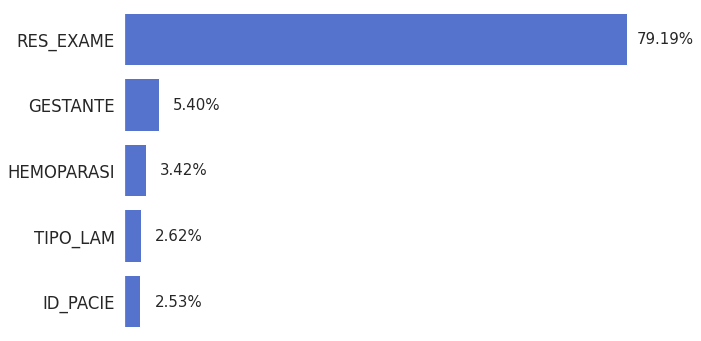

In [ ]:
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.family':'DejaVu Sans',
      'font.size' : 15}

plt.rcParams.update(rc)

ax = sns.barplot(data=df_featImport, x='feat_importance', y=df_featImport.index, color='royalblue')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('')
#ax.set_yticklabels([textwrap.fill(e, 35) for e in df_plot.index], size=20)
ax.set(xticklabels=[])

sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=True, offset=None, trim=False)

for p in ax.patches:
    width = p.get_width()
    plt.text(0.06+p.get_width(), p.get_y()+0.5*p.get_height(),
             '{:1.2f}%'.format(width*100),
             ha='center', va='center')

plt.tight_layout()
plt.savefig('./feature_importance.pdf')
plt.show()

In [ ]:
lrModel = LogisticRegression()
lrModel.fit(X_train, y_train)

[WARNING] lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_test_pred = lrModel.predict(X_test)
y_test_predProba = lrModel.predict_proba(X_test)

In [ ]:
generate_performance_stats(y_test, y_test_pred)

Accuracy: 0.9302688567459345

Auc-macro: 0.8218882023908447

Auc-weighted: 0.8218882023908447

Confusion Matrix: 
Predicted      0       1
Actual                  
0          27881   14633
1           2433  199793

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.92      0.66      0.77     42514
   Tratamento 11       0.93      0.99      0.96    202226

        accuracy                           0.93    244740
       macro avg       0.93      0.82      0.86    244740
    weighted avg       0.93      0.93      0.93    244740




In [ ]:
dtModel = DecisionTreeClassifier()
dtModel.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_test_pred = dtModel.predict(X_test)
y_test_predProba = dtModel.predict_proba(X_test)

In [ ]:
generate_performance_stats(y_test, y_test_pred)

Accuracy: 0.9130056386369209

Auc-macro: 0.8153895179069806

Auc-weighted: 0.8153895179069806

Confusion Matrix: 
Predicted      0       1
Actual                  
0          28306   14208
1           7083  195143

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.80      0.67      0.73     42514
   Tratamento 11       0.93      0.96      0.95    202226

        accuracy                           0.91    244740
       macro avg       0.87      0.82      0.84    244740
    weighted avg       0.91      0.91      0.91    244740




#### 5 folds e Sem Undersampling
A cada iteração do processo de validação cruzada, a base de treinamento permanece desbalanceada. 

In [ ]:
n_folds = 5
results_exp2, models_pred_exp2 = perform_cv(df_train, models, n_folds, False)

Model: XGBoost

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Accuracy: 0.9342983750035753

Auc: 0.9272405089676972

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        114584   10267
1.0         54052  800053

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.68      0.92      0.78    124851
   Tratamento 11       0.99      0.94      0.96    854105

        accuracy                           0.93    978956
       macro avg       0.83      0.93      0.87    978956
    weighted avg       0.95      0.93      0.94    978956


########################################################

Model: Logistic

Fold[1]



[WARNING] lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fold[2]



[WARNING] lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Fold[3]

Fold[4]

Fold[5]

Accuracy: 0.8855137513841276

Auc: 0.8912812753122242

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0         63804    7245
1.0        104832  803075

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.38      0.90      0.53     71049
   Tratamento 11       0.99      0.88      0.93    907907

        accuracy                           0.89    978956
       macro avg       0.68      0.89      0.73    978956
    weighted avg       0.95      0.89      0.91    978956


########################################################

Model: DecisionTree

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Accuracy: 0.9007861436060456

Auc: 0.8240027374596015

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        123143   51633
1.0         45493  758687

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.73     

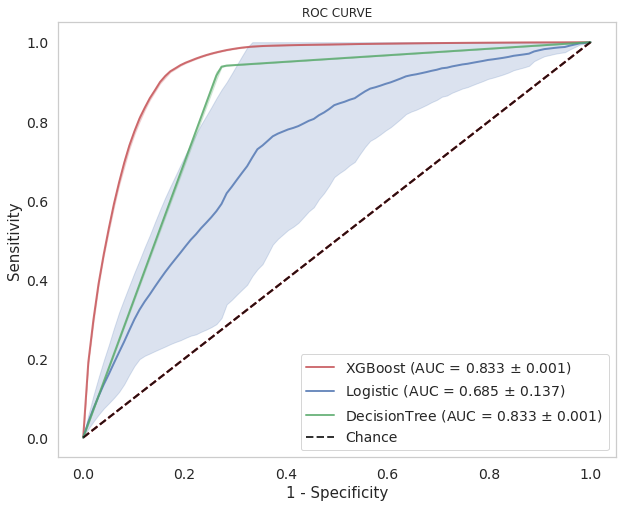

In [ ]:
plot_roc_curve(results_exp2, "roc_curve_unbalanced")

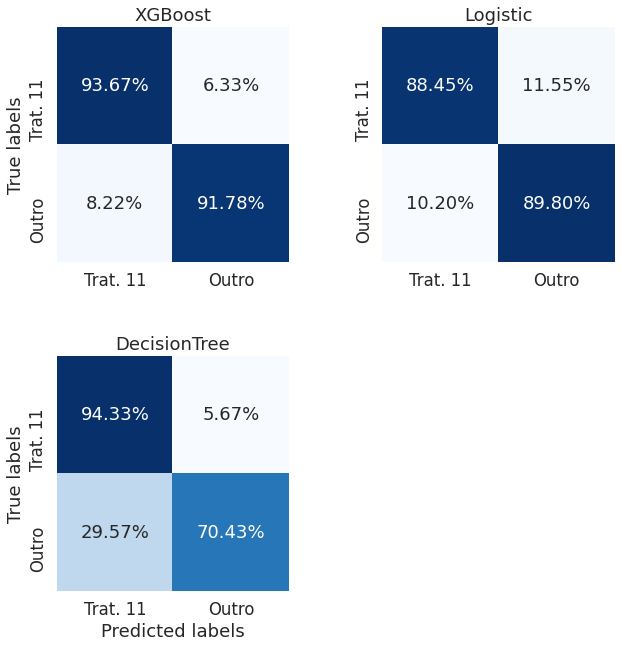

In [ ]:
plot_confusion_matrix(results_exp2, ['Trat. 11', 'Outro'], "confusion_matrix")

#### 5 folds, Undersampling e One-Hot Encoding 

In [ ]:
df_train_dummy = df_train.copy()

In [ ]:
df_train_dummy.columns


Index(['tipo_lam', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'sintomas',
       'cod_ocup', 'mun_infe', 'loc_infe', 'res_exam', 'qtd_cruz',
       'hemoparasi', 'exame', 'gestante', 'vivax', 'falciparum', 'niv_esco',
       'target'],
      dtype='object')

In [ ]:
cols_to_convert = df_train_dummy.columns
cols_to_convert = cols_to_convert.drop(['mun_infe', 'loc_infe', 'id_pacie', 'target'])
cols_to_convert

Index(['tipo_lam', 'id_dimea', 'sexo', 'raca', 'sintomas', 'cod_ocup',
       'res_exam', 'qtd_cruz', 'hemoparasi', 'exame', 'gestante', 'vivax',
       'falciparum', 'niv_esco'],
      dtype='object')

In [ ]:
df_train_dummy = pd.get_dummies(df_train_dummy, columns=cols_to_convert, drop_first=True)

In [ ]:
df_train_dummy.head()

,id_pacie,mun_infe,loc_infe,target,tipo_lam_1,tipo_lam_2,id_dimea_1,sexo_1,raca_1,raca_2,raca_3,raca_4,sintomas_1,cod_ocup_1,cod_ocup_2,cod_ocup_3,cod_ocup_4,cod_ocup_5,cod_ocup_6,cod_ocup_7,cod_ocup_8,cod_ocup_9,cod_ocup_10,cod_ocup_11,res_exam_1,res_exam_2,res_exam_3,res_exam_4,res_exam_5,res_exam_6,res_exam_7,res_exam_8,res_exam_9,qtd_cruz_1,qtd_cruz_2,qtd_cruz_3,qtd_cruz_4,qtd_cruz_5,hemoparasi_1,hemoparasi_2,hemoparasi_3,hemoparasi_4,exame_1,gestante_1,gestante_2,gestante_3,gestante_4,gestante_5,vivax_1,falciparum_1,niv_esco_1,niv_esco_2,niv_esco_3,niv_esco_4,niv_esco_5,niv_esco_6,niv_esco_7,niv_esco_8,niv_esco_9
2083724,25.0,130260.0,459.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3677474,1.0,140028.0,93.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3113669,9.0,150110.0,120.0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2075483,11.0,130060.0,15.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2086926,6.0,130120.0,386.0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
n_folds = 5
results_exp3, models_pred_exp3 = perform_cv(df_train_dummy, models, n_folds, True)

Model: XGBoost

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Accuracy: 0.9146836017144795

Auc: 0.8429862249731677

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        136430   51315
1.0         32206  759005

Classification Report: 
                  precision    recall  f1-score   support

Outro Tratamento       0.81      0.73      0.77    187745
   Tratamento 11       0.94      0.96      0.95    791211

        accuracy                           0.91    978956
       macro avg       0.87      0.84      0.86    978956
    weighted avg       0.91      0.91      0.91    978956


########################################################

Model: Logistic

Fold[1]

Fold[2]

Fold[3]

Fold[4]

Fold[5]

Accuracy: 0.7744454296209431

Auc: 0.6545489927264846

Confusion Matrix: 
Predicted     0.0     1.0
Actual                   
0.0        103627  155799
1.0         65009  654521

Classification Report: 
                  precision    recall  f1-score   support

Ou

In [ ]:
plot_roc_curve(results_exp3, "roc_curve_balanced_ohe")

### Testar o modelo na base de teste

In [ ]:
#Gerar o modelo utilizando toda a base de treinamento. A base será balanceada, pois os modelos avaliados utilizando a validação cruzada com undersampling 
#tiveram melhor desempenho preditivo.
X_train_balanced = create_balanced_dataset(df_train, 1.0)

In [ ]:
df_plot = X_train_balanced.groupby(['target']).agg(
    total = ('target', 'count')
)

In [ ]:
df_plot

In [ ]:
#Treinando um modelo utilizando XGBoost
clf = XGBClassifier()
y_train_balanced = X_train_balanced['target']
X_train_balanced.drop(['target'], axis=1, inplace=True)

In [ ]:
clf.fit(X_train_balanced, y_train_balanced)

In [ ]:
#Obter as probalidades de cada exemplo do conjuneto de teste
y_test = X_test['target']
X_test.drop(['target'], axis=1, inplace=True)

In [ ]:
y_test_pred = clf.predict(X_test)

In [ ]:
generate_performance_stats(y_test_pred, y_test)

In [ ]:
#Salvando o modelo
import joblib
joblib.dump(clf, 'xgb_model.pkl')

In [ ]:
clf.save_model('xgb_model.bin')

In [ ]:
xgb_model = XGBClassifier()
xgb_model.load_model('xgb_model.json')

In [ ]:
xgb_model = joblib.load('xgb_model.pkl')

In [ ]:
X_test[1:2]

In [ ]:
xy_test_pred = xgb_model.predict(X_test[1:2])

In [ ]:
print(y_test_pred)